In [1]:
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import wrangle
pd.set_option('display.max_columns', None)
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Zillow Clustering Project Report

By Jeremy Lagunas
08/09/2022

# Project Description

I worked with the zillow data to try and find useful clusters in the data. These clusters were used to generate models which predicted log error.

# Project Goals:
- Generate informative visuals to show how variables interact.
- Find which features to use in a predictive model.
- Create a model which outperforms the baseline. 

# Acquire

In [2]:
# Using this function from the wrangle.py to acquire the data.
df = wrangle.new_zillow_data()

# Prepare

In [3]:
# Starting shape of the data.
df.shape

(52319, 68)

In [4]:
# This function displays the number of nulls per column as well as the percent of the column those nulls make up.
wrangle.null_counter(df).T

name,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
num_rows_missing,0,0,38704,52249,52272,0,0,52319,18665,135,51930,47948,81,246,52319,52319,47948,52154,0,45086,135,34335,34335,50805,18470,0,0,366,41242,51454,51876,51248,42329,0,0,18558,0,1036,0,33338,26,0,52272,45602,52243,18558,50384,52256,114,37787,52238,82,1,0,1,4,50251,50251,121,0,0,38704,52249,52319,18470,0,52272,52243
pct_rows_missing,0.0,0.0,0.739769,0.998662,0.999102,0.0,0.0,1.0,0.356754,0.00258,0.992565,0.916455,0.001548,0.004702,1.0,1.0,0.916455,0.996846,0.0,0.861752,0.00258,0.656263,0.656263,0.971062,0.353027,0.0,0.0,0.006996,0.78828,0.983467,0.991533,0.979529,0.809056,0.0,0.0,0.354709,0.0,0.019802,0.0,0.637206,0.000497,0.0,0.999102,0.871615,0.998547,0.354709,0.963015,0.998796,0.002179,0.722242,0.998452,0.001567,0.000019,0.0,0.000019,0.000076,0.960473,0.960473,0.002313,0.0,0.0,0.739769,0.998662,1.0,0.353027,0.0,0.999102,0.998547


In [3]:
# This function drops each column which does not have at least 75% non-null data.
df = wrangle.null_dropper(df, 0.75, 0.75)

In [4]:
# This function drops remaining NaN's, drops columns with redundant information, creates a column for half baths, and changes the fips column to a county column. For more information, please see the wrangle.py file.
df = wrangle.zillow_clean(df)

In [7]:
df.head()

,id,parcelid,bath,bed,calculatedbathnbr,square_feet,county,fullbathcnt,latitude,longitude,lot_square_feet,rawcensustractandblock,id_city,id_county,id_zip,yearbuilt,appraisal,assessmentyear,logerror,transactiondate,half_bath
0,1727539,14297519,3.5,4.0,3.5,3100.0,Orange County,3.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,1.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,Ventura County,1.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,0.0
2,11677,14186244,2.0,3.0,2.0,1243.0,Orange County,2.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,0.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,LA County,3.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,96330.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,0.0
4,781532,12095076,3.0,4.0,3.0,2962.0,LA County,3.0,34145202.0,-118179824.0,63000.0,6.037461e+07,47019.0,3101.0,96293.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,0.0


### Split

In [5]:
# Splitting the data before beginning exploration.
train, valid_test = train_test_split(df, test_size = 0.3, random_state = 123)

validate, test = train_test_split(valid_test, test_size = 0.5, random_state = 123)

In [6]:
print(train.shape, validate.shape, test.shape)

(35391, 21) (7584, 21) (7584, 21)


# Explore

### 1. How does log error compare between the three counties?

In [10]:
# Establishing variables representing the average log error for each county.
avg_LA_logerror = df.logerror[df.county == 'LA County'].mean()
avg_Orange_logerror = df.logerror[df.county == 'Orange County'].mean()
avg_Ventura_logerror = df.logerror[df.county == 'Ventura County'].mean()

In [11]:
# x and y for the bar chart.
y = [avg_LA_logerror, avg_Orange_logerror, avg_Ventura_logerror]
x = ['LA County', 'Orange County', 'Ventura County']

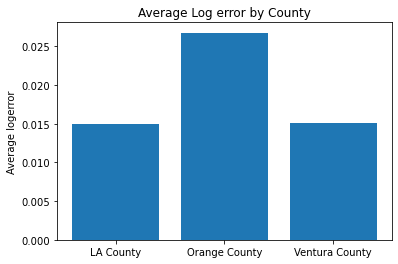

In [12]:
# This bar chart represents the Average Log Error by County.
plt.bar(x, y)
plt.ylabel('Average logerror')
plt.title('Average Log error by County')
plt.show()

Orange County appears to have a higher average log error.

### Null Hypothesis:
- There is no significant difference between the county's logerrors.

### Alternative Hypothesis
- There is a statistically significant difference between the county's logerrors. 

In [13]:
alpha = 0.05

f, p = stats.f_oneway(df[df['county'] == 'LA County'].logerror,
                     df[df['county'] == 'Orange County'].logerror,
                     df[df['county'] == 'Ventura County'].logerror)

f, p

(22.529040531309715, 1.660043739931129e-10)

I reject the Null Hypothesis.

### 2. How does size of a house in square feet affect log error?

In [45]:
# x and y for the bar chart
# y is the average log error per bin of house. These bins are based on square feet and are broken up as follows: < 2500 sqft, >= 2500 sqft & < 5000 sqft, >= 5000 sqft.
y=[df.logerror[df.square_feet < 2500].mean(),
df.logerror[(df.square_feet >= 2500) & (df.square_feet < 5000)].mean(),
df.logerror[df.square_feet >= 5000].mean()]

x=['small', 'medium', 'large']

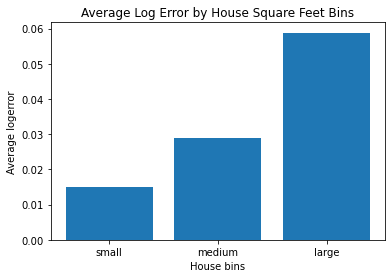

In [46]:
# Bar chart representing the difference in average log error by house bin.
plt.bar(x, y)
plt.xlabel('House bins')
plt.ylabel('Average logerror')
plt.title('Average Log Error by House Square Feet Bins')
plt.show()

It appears that larger houses have a larger average log error.

### Null Hypothesis:
- There is no significant difference between the logerrors according to house square footage.

### Alternative Hypothesis
- There is a statistically significant difference between the logerrors according to house square footage. 

In [16]:
alpha = 0.05

f, p = stats.f_oneway(df[df['square_feet'] < 2500].logerror,
                     df[(df['square_feet'] >= 2500) & (df['square_feet'] < 5000)].logerror,
                     df[df['square_feet'] >= 5000].logerror)

f, p

(44.00700236584575, 8.028208895897534e-20)

I reject the Null Hypothesis.

### 3. How does year built affect log error?

In [17]:
# x and y for the bar chart.
# y is the average log error per year built bins. The bins are broken up as follows: Before 1950, 1950-1979, 1980-Present.
y=[df.logerror[df.yearbuilt < 1950].mean(),
df.logerror[(df.yearbuilt >= 1950) & (df.square_feet < 1980)].mean(),
df.logerror[df.yearbuilt >= 1980].mean()]

x = ['Before 1950', '1950-1979', '1980-Present']

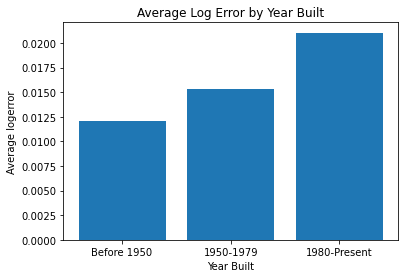

In [18]:
# This bar char represents the average log error by year built bin.
plt.bar(x, y)
plt.xlabel('Year Built')
plt.ylabel('Average logerror')
plt.title('Average Log Error by Year Built')
plt.show()

### Null Hypothesis:
- There is no significant difference between the logerrors according to year built. 

### Alternative Hypothesis
- There is a statistically significant difference between the logerrors according to year built.

In [19]:
alpha = 0.05

f, p = stats.f_oneway(df[df['yearbuilt'] < 1950].logerror,
                     df[(df['yearbuilt'] >= 1950) & (df['yearbuilt'] < 1980)].logerror,
                     df[df['yearbuilt'] >= 1980].logerror)

f, p

(9.361556106866363, 8.611533662895507e-05)

I reject the Null Hypothesis.

### 4. How does the number of half baths affect log error?

In [20]:
# x and y for the bar chart.
# y is the average log error by half bath bin. The bins are broken up as follows: None, One half bath, Two or more half baths.
y=[df.logerror[df.half_bath == 0.0].mean(),
df.logerror[(df.half_bath >= 1.0) & (df.half_bath < 2.0)].mean(),
df.logerror[df.half_bath >= 2.0].mean()]

x = ['None', 'One', 'Two of more']

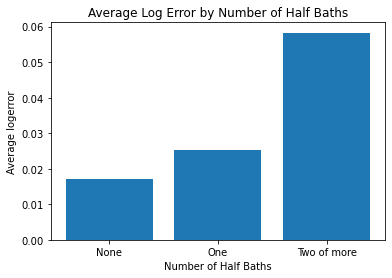

In [21]:
# This chart represents the average log error by half bath bin.
plt.bar(x, y)
plt.xlabel('Number of Half Baths')
plt.ylabel('Average logerror')
plt.title('Average Log Error by Number of Half Baths')
plt.show()

### Null Hypothesis:
- There is no significant difference between the logerrors according to the number of half baths. 

### Alternative Hypothesis
- There is a statistically significant difference between the logerrors according to the number of half baths.

In [22]:
alpha = 0.05

f, p = stats.f_oneway(df[df['half_bath'] == 0.0].logerror,
                     df[(df['half_bath'] >= 1.0) & (df['half_bath'] < 2.0)].logerror,
                     df[df['half_bath'] >= 2.0].logerror)

f, p

(8.537515866678534, 0.0001962591771208839)

I reject the Null Hypothesis.

# Clustering

In [7]:
# Creates dummy columns for each county.
dummies_train = pd.get_dummies(train.county)
dummies_validate = pd.get_dummies(validate.county)
dummies_test = pd.get_dummies(test.county)

# Adding dummy columns to train, val, and test datasets.
train = pd.concat([train, dummies_train], axis = 1)
validate = pd.concat([validate, dummies_validate], axis = 1)
test = pd.concat([test, dummies_test], axis = 1)

# Drop original county column.
train.drop(columns=['county'], inplace = True)
validate.drop(columns=['county'], inplace = True)
test.drop(columns=['county'], inplace = True)

# Drop transaction date to ensure dataset works with modeling. 
train.drop(columns=['transactiondate'], inplace=True)
validate.drop(columns=['transactiondate'], inplace=True)
test.drop(columns=['transactiondate'], inplace=True)

### Scale

In [9]:
# train
scaler = MinMaxScaler()

scaler.fit(train[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

train_scaled = scaler.transform(train[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

In [10]:
# validate
scaler = MinMaxScaler()

scaler.fit(validate[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

validate_scaled = scaler.transform(validate[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

In [11]:
# test
scaler = MinMaxScaler()

scaler.fit(test[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

test_scaled = scaler.transform(test[['bath', 'bed', 'square_feet', 'fullbathcnt', 'lot_square_feet', 'yearbuilt', 'appraisal', 'half_bath']])

In [13]:
# turn scaled data back into DataFrame

train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=['bath_scaled', 'bed_scaled', 'square_feet_scaled', 'fullbathcnt_scaled', 'lot_square_feet_scaled', 'yearbuilt_scaled', 'appraisal_scaled', 'half_bath_scaled'])
validate_scaled = pd.DataFrame(validate_scaled, index=validate.index, columns=['bath_scaled', 'bed_scaled', 'square_feet_scaled', 'fullbathcnt_scaled', 'lot_square_feet_scaled', 'yearbuilt_scaled', 'appraisal_scaled', 'half_bath_scaled'])
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=['bath_scaled', 'bed_scaled', 'square_feet_scaled', 'fullbathcnt_scaled', 'lot_square_feet_scaled', 'yearbuilt_scaled', 'appraisal_scaled', 'half_bath_scaled'])

In [14]:
# combine scaled columns with the original train, validate, and test datasets to have more to work with
train_scaled = pd.concat([train_scaled, train], axis = 1)
validate_scaled = pd.concat([validate_scaled, validate], axis = 1)
test_scaled = pd.concat([test_scaled, test], axis = 1)

### House Cluster

In [16]:
# This cluster contains features which pertain to the house itself, i.e. square feet, bedrooms, half baths. These are all scaled.
house_cluster = train_scaled[['square_feet_scaled', 'bed_scaled', 'half_bath_scaled']]
k_range = range(2,20)

In [17]:
# Creating the house clusters for the validate data.
house_cluster_validate = validate_scaled[['square_feet_scaled', 'bed_scaled', 'half_bath_scaled']]
k_range = range(2,20)

In [18]:
# train
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(house_cluster)

train_scaled['house_cluster'] = kmeans.predict(house_cluster)
train_scaled.house_cluster = train_scaled.house_cluster.astype('category')

In [19]:
# validate
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(house_cluster_validate)

validate_scaled['house_cluster'] = kmeans.predict(house_cluster_validate)
validate_scaled.house_cluster = validate_scaled.house_cluster.astype('category')

In [34]:
y = (train_scaled.logerror[train_scaled.house_cluster == 0].mean(),
      train_scaled.logerror[train_scaled.house_cluster == 1].mean(),
      train_scaled.logerror[train_scaled.house_cluster == 2].mean())

x = ['House Cluster 0', 'House Cluster 1', 'House Cluster 2']

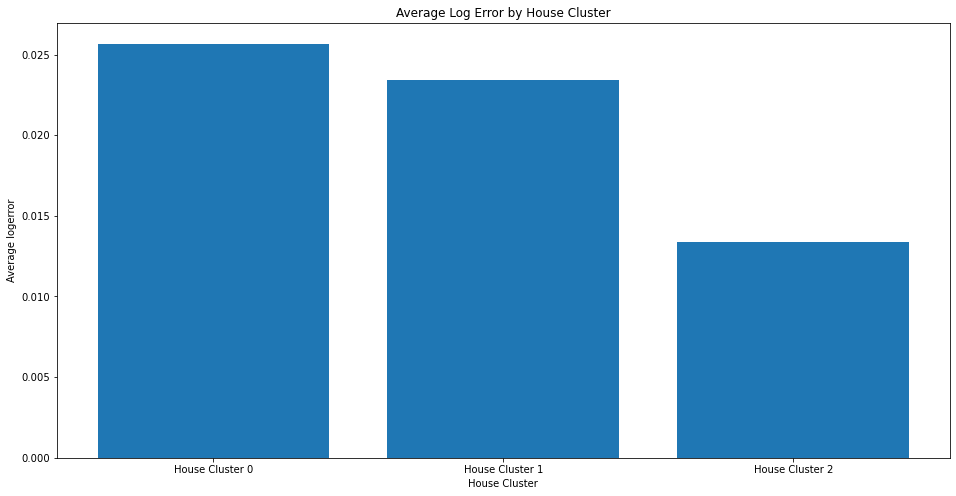

In [35]:
# This chart represents the average log error for each house cluster.
plt.figure(figsize=(16,8))
plt.bar(x, y)
plt.xlabel('House Cluster')
plt.ylabel('Average logerror')
plt.title('Average Log Error by House Cluster')
plt.show()

- House cluster 0: medium square feet with more bedrooms and half baths. 
- House cluster 1: medium to large square feet with Medium to High number of bedrooms and Low Half Baths. 
- House cluster 2: small square feet with low number of bedrooms and half baths.

### Age/Size Cluster

In [20]:
# These clusters contain features which are related to the age and size of the house, i.e. year built, square feet, lot sqaure feet. These are all scaled.
age_size_cluster_train = train_scaled[['yearbuilt_scaled', 'square_feet_scaled', 'lot_square_feet_scaled']]
k_range = range(2,20)

In [21]:
#train
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(age_size_cluster_train)

train_scaled['age_size_cluster'] = kmeans.predict(age_size_cluster_train)
train_scaled.age_size_cluster = train_scaled.age_size_cluster.astype('category')

In [22]:
# validate

age_size_cluster_validate = validate_scaled[['yearbuilt_scaled', 'square_feet_scaled', 'lot_square_feet_scaled']]
k_range = range(2,20)

kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(age_size_cluster_validate)

validate_scaled['age_size_cluster'] = kmeans.predict(age_size_cluster_validate)
validate_scaled.age_size_cluster = validate_scaled.age_size_cluster.astype('category')

In [23]:
y = (train_scaled.logerror[train_scaled.age_size_cluster == 0].mean(),
      train_scaled.logerror[train_scaled.age_size_cluster == 1].mean(),
      train_scaled.logerror[train_scaled.age_size_cluster == 2].mean())

x = ['Age/size Cluster 0', 'Age/size Cluster 1', 'Age/size Cluster 2']

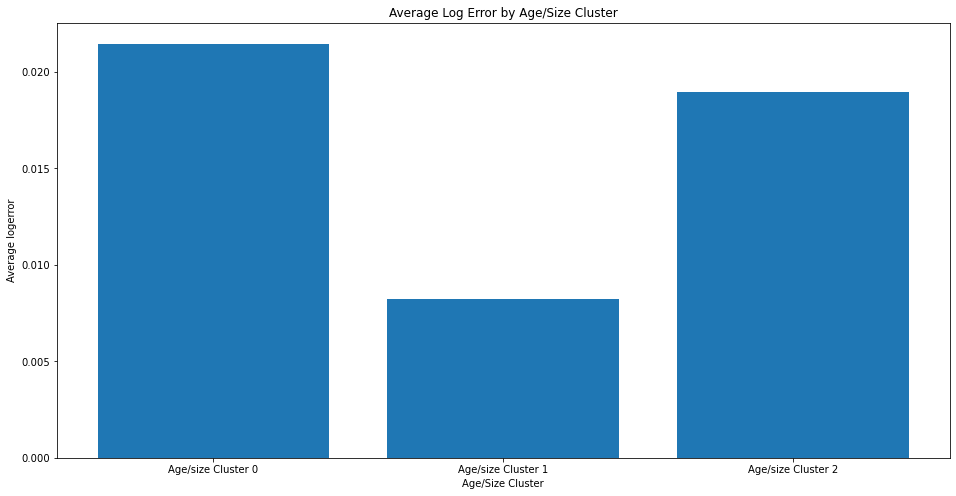

In [42]:
# This chart represents the average log error for each age/size cluster.
plt.figure(figsize=(16,8))
plt.bar(x, y)
plt.xlabel('Age/Size Cluster')
plt.ylabel('Average logerror')
plt.title('Average Log Error by Age/Size Cluster')
plt.show()

Age/size clusters 0 and 2 have higer average log errors. 

- Cluster 0 are the larger, older houses.
- Cluster 1 are the smaller, newer houses.
- Cluster 2 are the smaller, medium aged houses. 

### - Null Hypothesis: There is no difference in log error between the age/size clusters.

### - Alternative Hypothesis: There is a difference in log error between the age/size clusters.

In [44]:
alpha = 0.05

f, p = stats.f_oneway(train_scaled.logerror[train_scaled.age_size_cluster == 0], train_scaled.logerror[train_scaled.age_size_cluster == 1], train_scaled.logerror[train_scaled.age_size_cluster == 2])
f, p

(11.329146170825815, 1.206115264662951e-05)

# Modeling

### Baseline

In [24]:
# Making dummy columns for house and age/size clusters.
# train
dummy_df_train = pd.get_dummies(train_scaled[['house_cluster', 'age_size_cluster']])
train_scaled = pd.concat([train_scaled, dummy_df_train], axis = 1)
# validate
dummy_df_validate = pd.get_dummies(validate_scaled[['house_cluster', 'age_size_cluster']])
validate_scaled = pd.concat([validate_scaled, dummy_df_validate], axis = 1)

In [25]:
# Separating x and y data.
y_train = train_scaled.logerror
y_validate = validate_scaled.logerror
y_test = test_scaled.logerror

x_train = train_scaled.drop(columns=['logerror'])
x_validate = validate_scaled.drop(columns=['logerror'])
x_test = test_scaled.drop(columns=['logerror'])

In [26]:
# Converting y data back into a DataFrame
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [27]:
# baseline predictor
# This is the average log error for the train data.
y_train.logerror.mean()

0.01797354929457556

In [28]:
# Baseline performance
y_train['baseline'] = y_train.logerror.mean()
y_validate['baseline'] = y_validate.logerror.mean()

rmse_train_baseline = mean_squared_error(y_train.logerror, y_train.baseline)**(1/2)
rmse_validate_baseline = mean_squared_error(y_validate.logerror, y_validate.baseline)**(1/2)

print(rmse_train_baseline, rmse_validate_baseline)

0.17399889316814268 0.18727602422316578


## Feature Engineering

### Select K Best

In [29]:
kbest = SelectKBest(f_regression, k=4)

kbest.fit(x_train, y_train.logerror)

SelectKBest(k=4, score_func=<function f_regression at 0x14cf94310>)

In [30]:
# Best performing features.
x_train.columns[kbest.get_support()]

Index(['bed_scaled', 'square_feet_scaled', 'bed', 'square_feet'], dtype='object')

In [31]:
# Model 1 data will use the four featueres picked by Select K Best.
x_train_model1 = x_train[['bed_scaled', 'square_feet_scaled', 'bed', 'square_feet']]
x_validate_model1 = x_validate[['bed_scaled', 'square_feet_scaled', 'bed', 'square_feet']]

# Model 2 data will use only the house clusters. 
x_train_model2 = x_train[['house_cluster_0', 'house_cluster_1', 'house_cluster_2']]
x_validate_model2 = x_validate[['house_cluster_0', 'house_cluster_1', 'house_cluster_2']]

# Model 3 will use only the age/size clusters.
x_train_model3 = x_train[['age_size_cluster_0', 'age_size_cluster_1', 'age_size_cluster_2']]
x_validate_model3 = x_validate[['age_size_cluster_0', 'age_size_cluster_1', 'age_size_cluster_2']]

## Linear Regression (OLS)

### Model 1

In [32]:
# Select K Best features
lm = LinearRegression(normalize=True)
lm.fit(x_train_model1, y_train.logerror)

y_train['log_error_pred_lm_model1'] = lm.predict(x_train_model1)
rmse_train = mean_squared_error(y_train.logerror, y_train.log_error_pred_lm_model1)**(1/2)

y_validate['log_error_pred_lm_model1'] = lm.predict(x_validate_model1)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.log_error_pred_lm_model1)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1738369963934923 
Validation/Out-of-Sample:  118033310190.152


### Model 2

In [33]:
# House clusters features
lm = LinearRegression(normalize=True)
lm.fit(x_train_model2, y_train.logerror)

y_train['log_error_pred_lm_model2'] = lm.predict(x_train_model2)
rmse_train = mean_squared_error(y_train.logerror, y_train.log_error_pred_lm_model2)**(1/2)

y_validate['log_error_pred_lm_model2'] = lm.predict(x_validate_model2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.log_error_pred_lm_model2)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.173916916092889 
Validation/Out-of-Sample:  0.18763017414420122


### Model 3

In [34]:
# Age/size clusters features
lm = LinearRegression(normalize=True)
lm.fit(x_train_model3, y_train.logerror)

y_train['log_error_pred_lm_model3'] = lm.predict(x_train_model3)
rmse_train = mean_squared_error(y_train.logerror, y_train.log_error_pred_lm_model3)**(1/2)

y_validate['log_error_pred_lm_model3'] = lm.predict(x_validate_model3)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.log_error_pred_lm_model3)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17394356235793906 
Validation/Out-of-Sample:  0.1874917089980152


## Lasso Lars

### Model 1

In [35]:
# Select K Best features
lars = LassoLars(alpha=1.0)
lars.fit(x_train_model1, y_train.logerror)

y_train['pred_lars'] = lars.predict(x_train_model1)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(x_validate_model1)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17399889316814268 
Validation/Out-of-Sample:  0.1872760414823965


### Model 2

In [36]:
# House clusters features
lars.fit(x_train_model2, y_train.logerror)

y_train['pred_lars2'] = lars.predict(x_train_model2)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lars2)**(1/2)

y_validate['pred_lars2'] = lars.predict(x_validate_model2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lars2)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17399889316814268 
Validation/Out-of-Sample:  0.1872760414823965


### Model 3

In [37]:
# Age/size clusters features.
lars.fit(x_train_model3, y_train.logerror)

y_train['pred_lars3'] = lars.predict(x_train_model3)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lars3)**(1/2)

y_validate['pred_lars3'] = lars.predict(x_validate_model3)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lars3)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17399889316814268 
Validation/Out-of-Sample:  0.1872760414823965


Lasso Lars is the best performing model.

## Test

In [41]:
x_test_model = x_test[['bed_scaled', 'square_feet_scaled', 'bed', 'square_feet']]

In [42]:
lars = LassoLars(alpha=1.0)
lars.fit(x_train_model1, y_train.logerror)

y_test['pred_lars'] = lars.predict(x_test_model)
rmse_test = mean_squared_error(y_test.logerror, y_test.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTest/Out-of-Sample: ", rmse_test)

RMSE for Lasso + Lars
Test/Out-of-Sample:  0.16719181703878794


In [43]:
print(rmse_train_baseline, rmse_validate_baseline)

0.17399889316814268 0.18727602422316578


# Conclusion

The model's performance on the Test data outperformed the baseline by 11%.

### Exploration Questions:
    1. How does log error compare between the three counties?
    Log error is highest in Orange County.
    
    2. How does the size of a house in square feet affect log error?
    The larger houses tend to have larger log errors.
    
    3. How does the year buiult affect log error?
    Newer houses tend to have larger log errors.
    
    4. How does the number of half baths affect log error?
    Houses with two or more half baths tend to have larger log errors. 

### Recommendations:
- Implement any lessons learned from today's presentation in our process for improving log error. 

### Next Steps:
- Utilize different variables for new clusters.
- Refine the models by changing hyperparameters and model features.